In [1]:
from pathlib import Path

import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
df = pd.read_csv('../data/02_intermediate/dmd_index.csv', index_col=0)

In [3]:
features = ['group', 'treatment', 'center', 'patient', 'slice', 'modality', 'm', 'dz', 'study_no', 'timepoints']

filtered = df[(df.keep) & (df.set == 'train') & (df.treatment == 'CONTROL') & (df.slice == 'mid')][features]

filtered.head(10)

,group,treatment,center,patient,slice,modality,m,dz,study_no,timepoints
5,GROUP_1,CONTROL,UCLA,16-000297-007,mid,cine,2.0,1.6,70,30
7,GROUP_1,CONTROL,UCLA,16-000297-007,mid,tag,NaN,NaN,7,25
14,GROUP_1,CONTROL,UCLA,16-000297-015,mid,tag,NaN,NaN,8,25
15,GROUP_1,CONTROL,UCLA,16-000297-015,mid,cine,2.0,-3.6,69,30
18,GROUP_1,CONTROL,UCLA,16-000297-016,mid,tag,NaN,NaN,28,1
25,GROUP_1,CONTROL,UCLA,16-000297-002,mid,cine,2.0,1.6,94,30
26,GROUP_1,CONTROL,UCLA,16-000297-002,mid,tag,NaN,NaN,9,25
32,GROUP_1,CONTROL,UCLA,16-000297-003,mid,cine,1.0,0.0,54,30
33,GROUP_1,CONTROL,UCLA,16-000297-003,mid,tag,NaN,NaN,12,25
40,GROUP_1,CONTROL,UCLA,16-000297-004,mid,cine,2.0,1.2,83,30


In [4]:
cine_path = df.loc[5].path
tagg_path = df.loc[7].path

In [5]:
def get_images(path: str) -> np.ndarray:
    path = Path(path)
    dcm_images = [f for f in path.iterdir() if f.is_file() and f.suffix == ".dcm"]

    res = map(
        lambda ds: (ds.InstanceNumber, ds.pixel_array),
        map(pydicom.dcmread, dcm_images),
    )
    return np.array(list(zip(*sorted(res, key=lambda item: item[0])))[1])

In [6]:
tagg = get_images(tagg_path)
cine = get_images(cine_path)

print(f'Extracted tagged image {tagg.shape} and according cine {cine.shape}')

Extracted tagged image (25, 180, 224) and according cine (30, 144, 192)


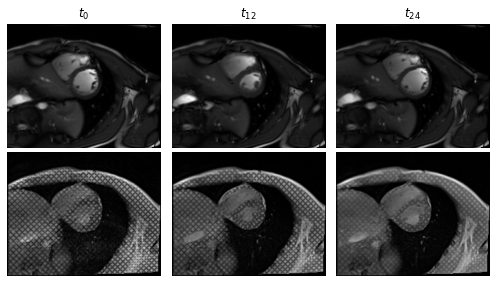

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(7, 4))

for i, t in enumerate([0, 12, 24]):
    ax[0, i].imshow(cine[int(t * 1.2)][:137, 20:190], cmap='gray'), ax[0, i].axis('off')
    ax[0, i].set_title(r'$t_{%s}$' % t)
    ax[1, i].imshow(tagg[t], cmap='gray'), ax[1, i].axis('off')

plt.tight_layout()
plt.savefig('../../figures/cine-vs-tagged.pdf', bbox_inches='tight')
plt.show()